<div align="center" style="color:powderblue; background-color:#2e2e2e; padding:20px; border-radius:10px;">

# Aprendizaje Profundo

### Grado en Ciencia de Datos

**Universidad Internacional de la Rioja (UNIR)**  
**Profesor:** Xuan González  
**Curso:** 2024-2025


**Complemento a la tarea 1**

**Entrenamiento de una red neuronal para clasificar hojas sanas y enfermas**

---

</div>

# Clasificación de hojas: sanas o enfermas usando una CNN en PyTorch

En este notebook vamos a entrenar una CNN para clasificar imágenes de hojas en dos categorías: sanas o enfermas.

Más info sobre el dataset y cómo descargarlo:

https://www.tensorflow.org/datasets/catalog/plant_leaves?hl=es

## Preprocesado de las imágenes

Las imágenes originales miden 6000x4000. Queremos primero recortar las imágenes para eliminar 1000 píxeles a la izquierda y 1000 a la derecha, quedando una imagen cuadrada de 4000x4000. Luego las redimensionamos a 224x224.

Guardaremos estas imágenes con el sufijo `"_resized"` en el mismo directorio. Si la imagen `"_resized.JPG"` ya existe, no haremos el procesamiento de nuevo.

Esta celda se debe ejecutar antes de la carga de datos, de forma que cuando creemos los dataloaders, ya carguemos sólo las imágenes redimensionadas.

In [1]:
import os
import glob
from PIL import Image

def preprocess_images(root):
    # Navegamos por todas las subcarpetas (plantas / healthy / diseased)
    for plant_dir in os.listdir(root):
        plant_path = os.path.join(root, plant_dir)
        if os.path.isdir(plant_path):
            # Buscamos en las carpetas healthy y diseased
            for condition in ["healthy", "diseased"]:
                condition_path = os.path.join(plant_path, condition)
                if os.path.isdir(condition_path):
                    # Procesamos todas las imágenes .JPG
                    for img_file in glob.glob(os.path.join(condition_path, "*.JPG")):
                        # Comprobar si ya existe la versión redimensionada
                        if "_resized" in img_file:
                            continue
                        base, ext = os.path.splitext(img_file)
                        dirpath, name = os.path.split(base)
                        root_resized = os.path.join(dirpath, "resized")
                        if not os.path.exists(root_resized):
                            os.makedirs(root_resized)

                        resized_file = os.path.join(root_resized, name + "_resized" + ext)
                        if os.path.exists(resized_file):
                            # Si ya existe, saltamos
                            continue
                        
                        # Abrimos la imagen original
                        print('Opening:', img_file)
                        with Image.open(img_file) as img:
                            # Verificamos el tamaño (debe ser 6000x4000)
                            w, h = img.size
                            # Recortamos 1000px de izq y der: 
                            # Queremos un recorte centrado: 
                            # Si el ancho es 6000, para llegar a 4000, quitamos 1000 a la izq y 1000 a la der.
                            left = 1000
                            upper = 0
                            right = w - 1000
                            lower = h  # altura permanece igual (4000)
                            cropped = img.crop((left, upper, right, lower))
                            
                            # Redimensionamos a 224x224
                            resized = cropped.resize((224,224), Image.BILINEAR)
                            
                            # Guardamos con "_resized"
                            resized.save(resized_file, "JPEG")

# Ejecutamos la función de preprocesado sobre el dataset
root_path = r"D:\projects\AI\datasets\leaves"
preprocess_images(root_path)

## 1. Generar la función para cargar el dataset con dataloaders

Vamos a crear un dataset personalizado que lea todas las imágenes `healthy` y `diseased` a través de todas las carpetas de plantas, y las etiquete con 0 (healthy) y 1 (diseased). Luego haremos un split aleatorio en train (80%) y test (20%). Posteriormente crearemos DataLoaders.

In [2]:
import os
import glob
from PIL import Image
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import random

root = root_path

# Parametros
IMG_SIZE = (224, 224)
TEST_RATIO = 0.2

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def load_dataset(root, img_size=(224,224)):
    # Lista para las imágenes y las etiquetas
    images = []
    labels = []
    
    # Obtenemos todas las rutas de imágenes
    for plant_dir in os.listdir(root):
        plant_path = os.path.join(root, plant_dir)
        if os.path.isdir(plant_path):
            healthy_path = os.path.join(plant_path, "healthy")
            diseased_path = os.path.join(plant_path, "diseased")
            
            if os.path.exists(healthy_path):
                for img_file in glob.glob(os.path.join(healthy_path, "*resized.JPG")):
                    images.append(img_file)
                    labels.append(0)
            if os.path.exists(diseased_path):
                for img_file in glob.glob(os.path.join(diseased_path, "*resized.JPG")):
                    images.append(img_file)
                    labels.append(1)
    
    # Convertimos labels a numpy
    labels = np.array(labels)
    
    # Dividimos en train y test
    train_imgs, test_imgs, train_lbls, test_lbls = train_test_split(images, labels, test_size=TEST_RATIO, random_state=42, shuffle=True)
    
    # Función para cargar y transformar una imagen
    def load_and_transform(path):
        img = Image.open(path).convert("RGB")
        img = img.resize(img_size)
        img = np.array(img).astype(np.float32) / 255.0
        # Normalizamos
        img[...,0] = (img[...,0]-mean[0])/std[0]
        img[...,1] = (img[...,1]-mean[1])/std[1]
        img[...,2] = (img[...,2]-mean[2])/std[2]
        # Transponemos a CxHxW
        img = np.transpose(img, (2,0,1))
        return img
    
    # Cargamos en memoria
    print("Cargando imágenes de train en memoria...")
    train_data = np.stack([load_and_transform(p) for p in train_imgs])
    print("Cargando imágenes de test en memoria...")
    test_data = np.stack([load_and_transform(p) for p in test_imgs])
    
    # Convertimos a tensores de PyTorch
    train_data = torch.from_numpy(train_data)
    train_lbls = torch.from_numpy(train_lbls).long()
    test_data = torch.from_numpy(test_data)
    test_lbls = torch.from_numpy(test_lbls).long()
    
    return (train_data, train_lbls), (test_data, test_lbls)

(train_data, train_labels), (test_data, test_labels) = load_dataset(root)

# Generador de batches
def get_batch_generator(data, labels, batch_size=64, shuffle=True):
    """
    Generador que produce batches de (X,y) a partir de datos precargados en memoria.
    """
    length = data.size(0)
    indices = np.arange(length)
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, length, batch_size):
        end_idx = min(start_idx+batch_size, length)
        batch_idx = indices[start_idx:end_idx]
        yield data[batch_idx], labels[batch_idx]


Cargando imágenes de train en memoria...
Cargando imágenes de test en memoria...


## 2. Cargar alguna imagen del train set y mostrar propiedades

Vamos a cargar una imagen del train set, registrar su tamaño y mostrar algunas propiedades. Luego mostraremos 10 imágenes aleatorias del train set con `matplotlib`.

Tamaño de la imagen del train dataset: torch.Size([3, 224, 224])
Etiqueta (0=sana, 1=enferma): tensor(1)


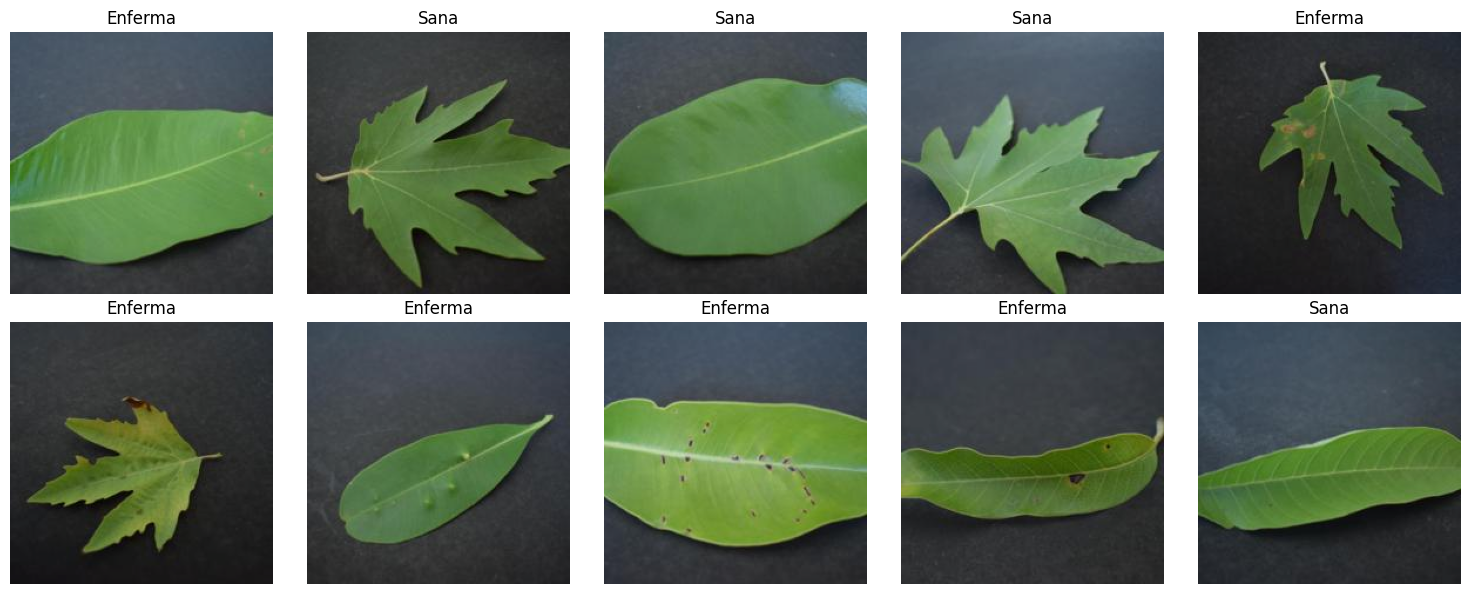

In [3]:
import matplotlib.pyplot as plt

# Cargamos una imagen del train dataset
img, label = train_data[0], train_labels[0]

print("Tamaño de la imagen del train dataset:", img.shape)  # shape: CxHxW
print("Etiqueta (0=sana, 1=enferma):", label)

# Mostramos 10 imágenes aleatorias
fig, axes = plt.subplots(2, 5, figsize=(15,6))
axes = axes.flatten()
random_indices = np.random.choice(len(train_data), 10, replace=False)

for ax, idx in zip(axes, random_indices):
    image, lbl = train_data[idx], train_labels[idx]
    # image es un tensor [C,H,W], necesitamos pasarlo a [H,W,C] para imshow
    npimg = image.permute(1,2,0).numpy()
    # Des-normalizamos para mostrar adecuadamente
    # Los valores se normalizaron con mean=[0.485,0.456,0.406] y std=[0.229,0.224,0.225]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = std * npimg + mean
    npimg = np.clip(npimg, 0, 1)
    ax.imshow(npimg)
    ax.set_title("Sana" if lbl==0 else "Enferma")
    ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Crear el device (GPU si está disponible)

Crearemos un dispositivo usando `torch.device`.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

Usando device: cuda


## 4. Crear el modelo CNN

El modelo tiene:
- 3 capas convolucionales con ReLU
- Dropout tras cada capa convolucional
- Capas de max pooling
- Luego aplanar y un MLP con dos capas ocultas y una salida con sigmoide

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Cambiamos el número de filtros:
        # Conv1: 8 filtros
        # Conv2: 16 filtros
        # Conv3: 32 filtros
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.dropout_conv = nn.Dropout(p=0.30)
        
        # Pooling 4x4
        self.pool = nn.MaxPool2d(2,2)
        
        # Después de 3 poolings 2x2 consecutivos, pasamos de 224x224 a 56x56
        # con 64 filtros en la última capa convolucional
        self.fc1 = nn.Linear(28*28*64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
        self.dropout_fc = nn.Dropout(p=0.50)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout_conv(x)
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.dropout_conv(x)
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.dropout_conv(x)
        x = self.pool(x)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout_fc(x)
        
        x = torch.sigmoid(self.fc3(x))
        return x

model1 = CNN().to(device)
print(model1)

# Contamos el número de parámetros total
total_params = sum(p.numel() for p in model1.parameters())
print(f"Total de parámetros: {total_params}")

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_conv): Dropout(p=0.3, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout_fc): Dropout(p=0.5, inplace=False)
)
Total de parámetros: 3237025


## 5. Crear funciones para entrenar el modelo

Usaremos `BCEWithLogitsLoss` si no hubiera sigmoide en la salida, pero hemos puesto sigmoide en la salida final, así que usamos `BCELoss`. Nuestro output es de tamaño [batch, 1], y la etiqueta es 0 o 1, por lo tanto usaremos `BCELoss()` con reshape apropiado.

Entrenaremos el modelo, al final de cada época evaluaremos en train (con el modelo en eval) y test, guardando las métricas. Mostraremos impresiones por época. Guardaremos la métrica de train también con el modelo en `.eval()` al final de la época para ser consistentes con dropout off en ambas evaluaciones.

Crearemos funciones `train_one_epoch`, `evaluate`.

In [6]:
import torch.optim as optim

def train_one_epoch(model, data, labels, optimizer, device, criterion, batch_size=64):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in get_batch_generator(data, labels, batch_size=batch_size, shuffle=True):
        X_batch = X_batch.to(device)
        y_batch = y_batch.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        outputs = outputs.view(-1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / data.size(0)
    return epoch_loss

def evaluate(model, data, labels, device, criterion, batch_size=64):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in get_batch_generator(data, labels, batch_size=batch_size, shuffle=False):
            X_batch = X_batch.to(device)
            y_batch = y_batch.float().to(device)
            outputs = model(X_batch)
            outputs = outputs.view(-1)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).long()
            total_correct += (preds == y_batch.long()).sum().item()
            total += X_batch.size(0)
    return total_loss / total, total_correct / total

## 6. Funciones para evaluar el modelo y representar curvas y matriz de confusión

Crearemos funciones para trazar las curvas de entrenamiento (pérdida y exactitud), y calcular y mostrar la matriz de confusión al final. Para la matriz de confusión, usamos `sklearn.metrics.confusion_matrix`.

In [7]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    
    # Pérdidas
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(test_losses, label='Test Loss')
    ax1.set_title('Pérdida vs Épocas')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    
    # Exactitud
    ax2.plot(train_accuracies, label='Train Acc')
    ax2.plot(test_accuracies, label='Test Acc')
    ax2.set_title('Exactitud vs Épocas')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Exactitud')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes=['Sana','Enferma']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thresh else 'black')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()
    plt.show()

## 7. Entrenar el modelo

Lanzamos el entrenamiento. Guardamos las métricas. Por defecto no tenemos data augmentation activo, pero se puede cambiar el booleano `data_augmentation`.

In [8]:
batch_size = 128
epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

criterion = nn.BCELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

for epoch in range(1, epochs+1):
    train_loss = train_one_epoch(model1, train_data, train_labels, optimizer, device, criterion, batch_size)
    # Evaluamos en train y test con el modelo en modo eval
    train_loss_eval, train_acc_eval = evaluate(model1, train_data, train_labels, device, criterion, batch_size)
    test_loss_eval, test_acc_eval = evaluate(model1, test_data, test_labels, device, criterion, batch_size)
    
    train_losses.append(train_loss_eval)
    test_losses.append(test_loss_eval)
    train_accuracies.append(train_acc_eval)
    test_accuracies.append(test_acc_eval)
    
    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc_eval:.4f} | Test Acc: {test_acc_eval:.4f}")

Epoch 1: Train Loss: 0.6940 | Train Acc: 0.6962 | Test Acc: 0.6837
Epoch 2: Train Loss: 0.6494 | Train Acc: 0.7006 | Test Acc: 0.6848
Epoch 3: Train Loss: 0.5838 | Train Acc: 0.7112 | Test Acc: 0.6903
Epoch 4: Train Loss: 0.5874 | Train Acc: 0.7545 | Test Acc: 0.7203
Epoch 5: Train Loss: 0.5194 | Train Acc: 0.7837 | Test Acc: 0.7525
Epoch 6: Train Loss: 0.4177 | Train Acc: 0.8195 | Test Acc: 0.7869
Epoch 7: Train Loss: 0.3822 | Train Acc: 0.8631 | Test Acc: 0.8135
Epoch 8: Train Loss: 0.3331 | Train Acc: 0.8014 | Test Acc: 0.7569
Epoch 9: Train Loss: 0.3026 | Train Acc: 0.8675 | Test Acc: 0.8069
Epoch 10: Train Loss: 0.2757 | Train Acc: 0.8992 | Test Acc: 0.8435
Epoch 11: Train Loss: 0.2607 | Train Acc: 0.9034 | Test Acc: 0.8479
Epoch 12: Train Loss: 0.2098 | Train Acc: 0.9025 | Test Acc: 0.8346
Epoch 13: Train Loss: 0.1932 | Train Acc: 0.9159 | Test Acc: 0.8413
Epoch 14: Train Loss: 0.2034 | Train Acc: 0.9339 | Test Acc: 0.8724
Epoch 15: Train Loss: 0.1919 | Train Acc: 0.9153 | Test A

## 8. Una vez finalizado el entrenamiento

- Pintamos las curvas de pérdida y exactitud.
- Mostramos la matriz de confusión en el dataset de test.
- Calculamos la tasa de falsos positivos (FPR = FP / (FP+TN)).
- Evaluamos el modelo en 10 imágenes aleatorias del dataset de test y mostramos la etiqueta real y el valor predicho.

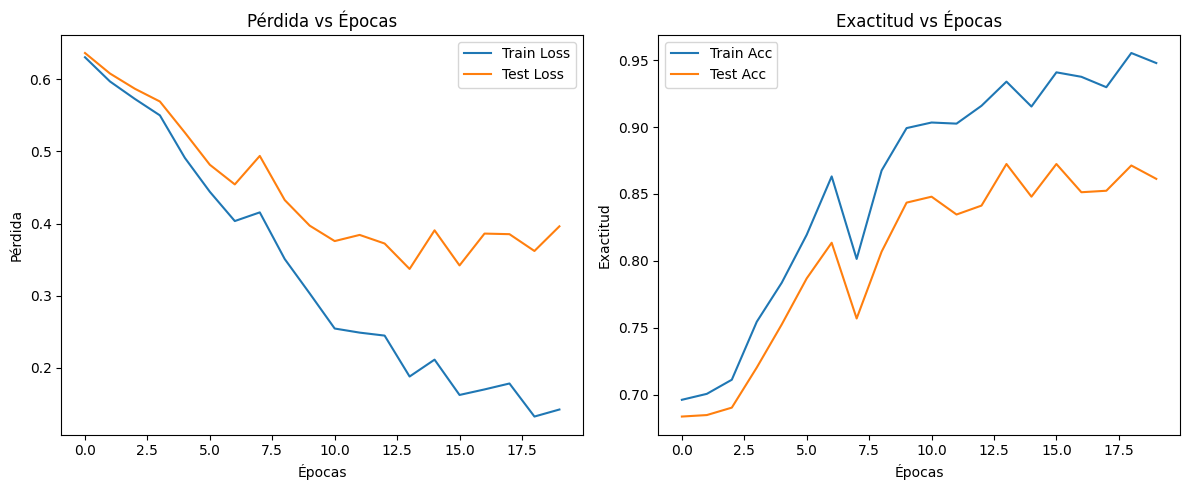

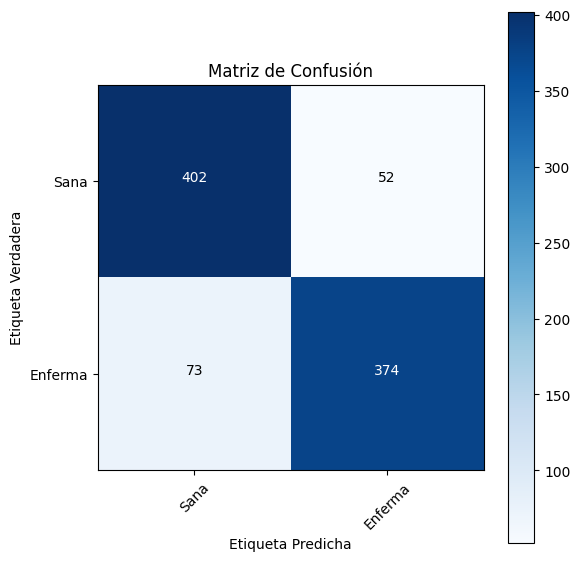

Tasa de falsos positivos (FPR): 11.45 %


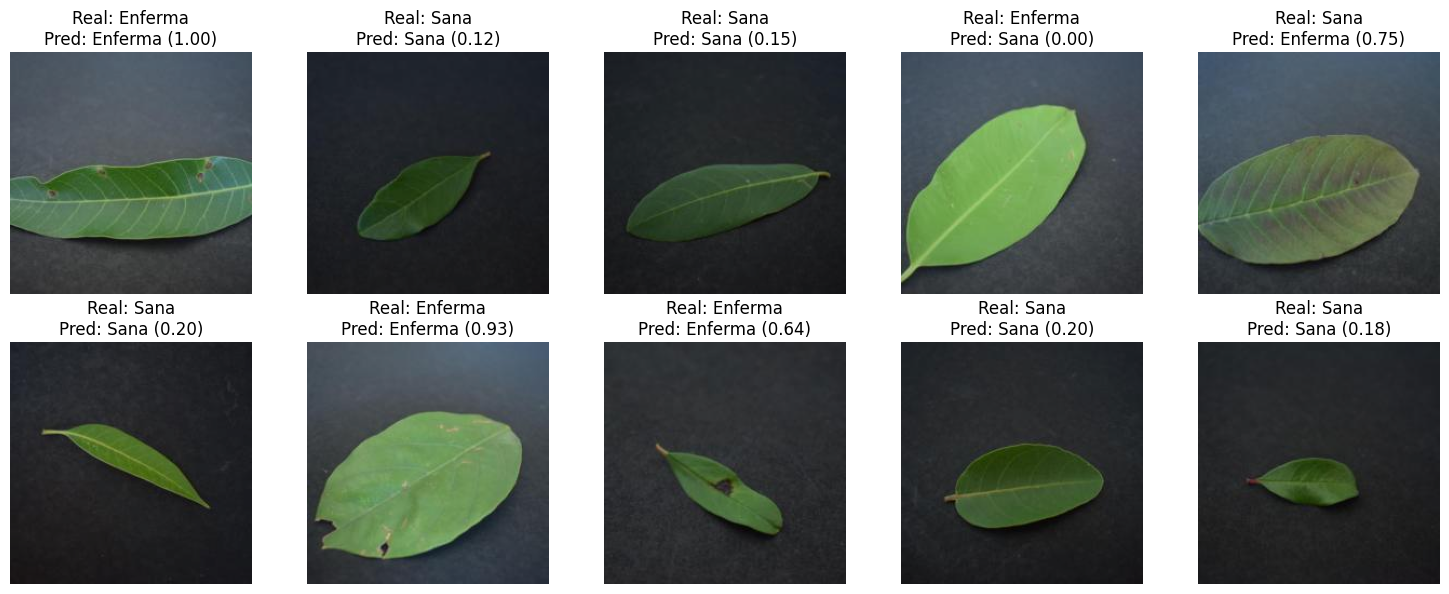

In [9]:
# Pintar curvas
plot_curves(train_losses, test_losses, train_accuracies, test_accuracies)

# Predecir en test para matriz de confusión
model1.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in get_batch_generator(test_data, test_labels, batch_size=64, shuffle=False):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        preds = (outputs.view(-1)>=0.5).long()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

plot_confusion_matrix(all_labels, all_preds, classes=['Sana','Enferma'])

# Calcular tasa de falsos positivos
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
fpr = fp/(fp+tn) if (fp+tn)>0 else 0
print(f"Tasa de falsos positivos (FPR): {fpr*100:.2f} %")

# Evaluar 10 imágenes aleatorias del test dataset
test_indices = np.random.choice(len(test_data), 10, replace=False)
model1.eval()
fig, axes = plt.subplots(2,5, figsize=(15,6))
axes = axes.flatten()
for ax, idx in zip(axes, test_indices):
    img, lbl = test_data[idx], test_labels[idx]
    # Predecimos
    input_img = img.unsqueeze(0).to(device) # [1,C,H,W]
    with torch.no_grad():
        output = model1(input_img)
    pred_prob = output.item()
    pred_label = 1 if pred_prob >= 0.5 else 0
    
    npimg = img.permute(1,2,0).numpy()
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    npimg = std*npimg + mean
    npimg = np.clip(npimg,0,1)
    ax.imshow(npimg)
    ax.set_title(f"Real: {'Sana' if lbl==0 else 'Enferma'}\nPred: {'Sana' if pred_label==0 else 'Enferma'} ({pred_prob:.2f})")
    ax.axis('off')

plt.tight_layout()
plt.show()

# 9. Uso de data augmentation


Vamos a redefinir la función `load_dataset` para que aplique data augmentation de tal forma que el tamaño del dataset se multiplique por 5.

La idea es:  
- Por cada imagen original, generaremos Nmult versiones aumentadas (cada una con transformaciones aleatorias).  
- Esto multiplicará el dataset por un factor de Nmult.  
- Podremos usar técnicas de data augmentation como `RandomHorizontalFlip`, `RandomRotation`, `ColorJitter`, etc.

Note que esto puede aumentar notablemente el consumo de memoria al almacenar las Nmult versiones en memoria RAM. Si el dataset es grande, podría no ser práctico. 

In [ ]:
import os
import glob
from PIL import Image
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import random
from torchvision import transforms

# Paramos el seed si queremos reproducibilidad (opcional)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Root del dataset
root = r"D:\projects\AI\datasets\leaves"

# Parametros
IMG_SIZE = (224, 224)
TEST_RATIO = 0.2

# Estadísticas de normalización de ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Definimos las transformaciones
# Primero la transformación base (resize, tensor, normalize):
base_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Definimos transformaciones de data augmentation que se aplicarán antes del base_transform
# Para generar variedad, usamos varias transformaciones aleatorias.
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

def augment_image(img, n=5):
    # Genera n imágenes aumentadas a partir de la imagen original
    augmented_images = []
    for _ in range(n):
        # Aplicamos augmentación aleatoria
        aug_img = augmentation_transform(img)
        # Luego la transformación base (normaliza y a tensor)
        aug_img = base_transform(aug_img)
        augmented_images.append(aug_img)
    return augmented_images

def load_dataset_aug(root, img_size=(224,224)):
    # Lista para las imágenes y las etiquetas
    images = []
    labels = []
    
    # Obtenemos todas las rutas de imágenes
    for plant_dir in os.listdir(root):
        plant_path = os.path.join(root, plant_dir)
        if os.path.isdir(plant_path):
            healthy_path = os.path.join(plant_path, "healthy")
            diseased_path = os.path.join(plant_path, "diseased")
            
            if os.path.exists(healthy_path):
                for img_file in glob.glob(os.path.join(healthy_path, "*resized.JPG")):
                    images.append(img_file)
                    labels.append(0)
            if os.path.exists(diseased_path):
                for img_file in glob.glob(os.path.join(diseased_path, "*resized.JPG")):
                    images.append(img_file)
                    labels.append(1)
    
    labels = np.array(labels)
    
    # Dividimos en train y test
    train_imgs, test_imgs, train_lbls, test_lbls = train_test_split(images, labels, test_size=TEST_RATIO, random_state=42, shuffle=True)
    
    # Carga y augmentación
    # Test no se aumenta, sólo se normaliza
    # Train se multiplica por Nmult con data augmentation
    print("Cargando y augmentando imágenes de train en memoria...")
    train_data_list = []
    train_labels_list = []
    Nmult = 5
    for path, lbl in zip(train_imgs, train_lbls):
        img = Image.open(path).convert("RGB")
        # Generamos Nmult versiones aumentadas
        aug_images = augment_image(img, n=Nmult) # lista de Nmult tensores
        # Añadimos las 5 imágenes y las 5 etiquetas
        train_data_list.extend(aug_images)
        train_labels_list.extend([lbl]*Nmult)
    
    print("Cargando imágenes de test en memoria (sin augmentation)...")
    test_data_list = []
    for path in test_imgs:
        img = Image.open(path).convert("RGB")
        # Sólo base_transform, sin augmentation
        img_t = base_transform(img)
        test_data_list.append(img_t)

    # Convertimos a tensores
    train_data = torch.stack(train_data_list)
    train_lbls = torch.tensor(train_labels_list, dtype=torch.long)
    test_data = torch.stack(test_data_list)
    test_lbls = torch.tensor(test_lbls, dtype=torch.long)
    
    return (train_data, train_lbls), (test_data, test_lbls)

In [11]:
(train_data, train_labels), (test_data, test_labels) = load_dataset_aug(root)

Cargando y augmentando imágenes de train en memoria...
Cargando imágenes de test en memoria (sin augmentation)...


Tamaño de la imagen del train dataset: torch.Size([3, 224, 224])
Etiqueta (0=sana, 1=enferma): tensor(1)


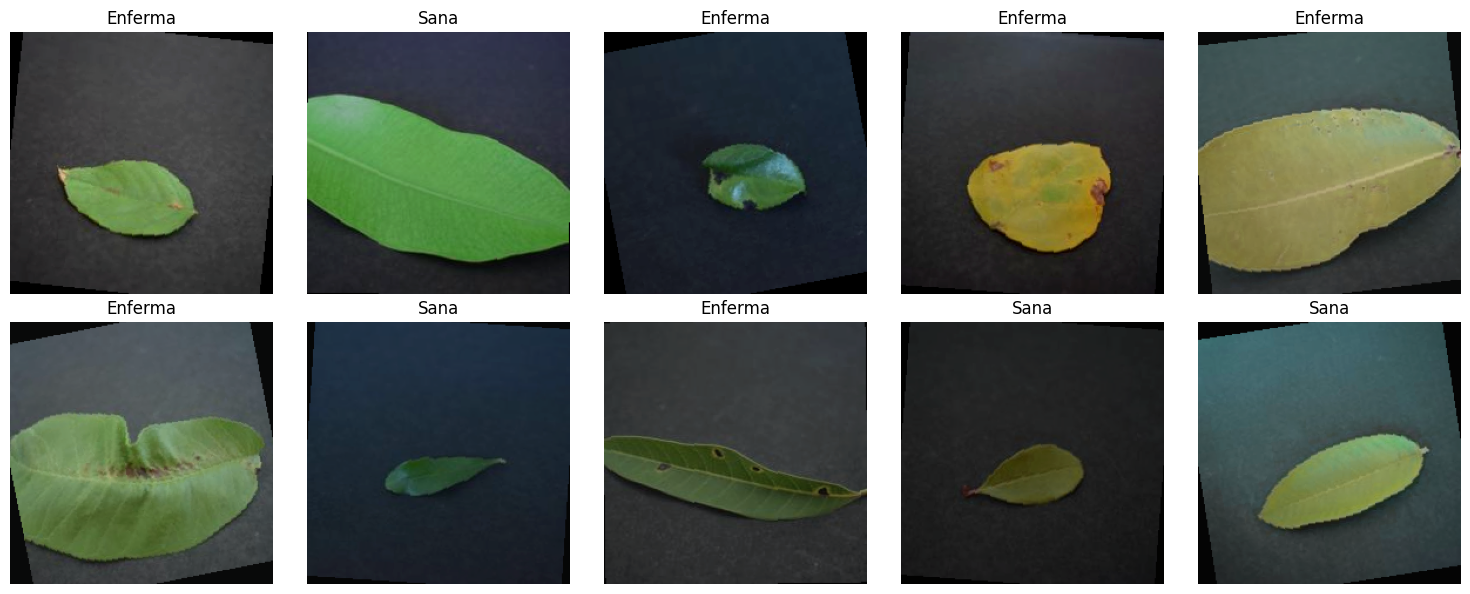

In [12]:
# Cargamos una imagen del train dataset
img, label = train_data[0], train_labels[0]

print("Tamaño de la imagen del train dataset:", img.shape)  # shape: CxHxW
print("Etiqueta (0=sana, 1=enferma):", label)

# Mostramos 10 imágenes aleatorias
fig, axes = plt.subplots(2, 5, figsize=(15,6))
axes = axes.flatten()
random_indices = np.random.choice(len(train_data), 10, replace=False)

for ax, idx in zip(axes, random_indices):
    image, lbl = train_data[idx], train_labels[idx]
    # image es un tensor [C,H,W], necesitamos pasarlo a [H,W,C] para imshow
    npimg = image.permute(1,2,0).numpy()
    # Des-normalizamos para mostrar adecuadamente
    # Los valores se normalizaron con mean=[0.485,0.456,0.406] y std=[0.229,0.224,0.225]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = std * npimg + mean
    npimg = np.clip(npimg, 0, 1)
    ax.imshow(npimg)
    ax.set_title("Sana" if lbl==0 else "Enferma")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
model2 = CNN().to(device)

batch_size = 128
epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.005)

for epoch in range(1, epochs+1):
    train_loss = train_one_epoch(model2, train_data, train_labels, optimizer, device, criterion, batch_size)
    # Evaluamos en train y test con el modelo en modo eval
    train_loss_eval, train_acc_eval = evaluate(model2, train_data, train_labels, device, criterion, batch_size)
    test_loss_eval, test_acc_eval = evaluate(model2, test_data, test_labels, device, criterion, batch_size)
    
    train_losses.append(train_loss_eval)
    test_losses.append(test_loss_eval)
    train_accuracies.append(train_acc_eval)
    test_accuracies.append(test_acc_eval)
    
    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc_eval:.4f} | Test Acc: {test_acc_eval:.4f}")

Epoch 1: Train Loss: 0.7251 | Train Acc: 0.5892 | Test Acc: 0.5716
Epoch 2: Train Loss: 0.6753 | Train Acc: 0.6737 | Test Acc: 0.6992
Epoch 3: Train Loss: 0.6176 | Train Acc: 0.7244 | Test Acc: 0.7691
Epoch 4: Train Loss: 0.5883 | Train Acc: 0.7443 | Test Acc: 0.7614
Epoch 5: Train Loss: 0.5290 | Train Acc: 0.7418 | Test Acc: 0.7603
Epoch 6: Train Loss: 0.4721 | Train Acc: 0.7731 | Test Acc: 0.7891
Epoch 7: Train Loss: 0.4377 | Train Acc: 0.7017 | Test Acc: 0.7092
Epoch 8: Train Loss: 0.4104 | Train Acc: 0.7658 | Test Acc: 0.7780
Epoch 9: Train Loss: 0.3647 | Train Acc: 0.7816 | Test Acc: 0.8024
Epoch 10: Train Loss: 0.3184 | Train Acc: 0.8091 | Test Acc: 0.8191
Epoch 11: Train Loss: 0.2957 | Train Acc: 0.8217 | Test Acc: 0.8402
Epoch 12: Train Loss: 0.2853 | Train Acc: 0.8348 | Test Acc: 0.8357
Epoch 13: Train Loss: 0.2581 | Train Acc: 0.8783 | Test Acc: 0.8890
Epoch 14: Train Loss: 0.2367 | Train Acc: 0.8706 | Test Acc: 0.8624
Epoch 15: Train Loss: 0.2246 | Train Acc: 0.8803 | Test A

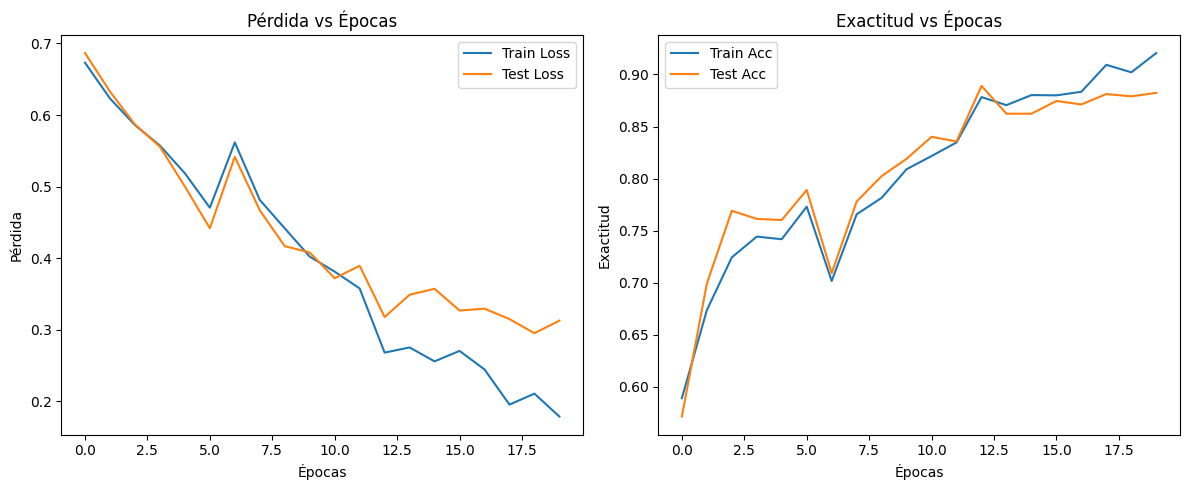

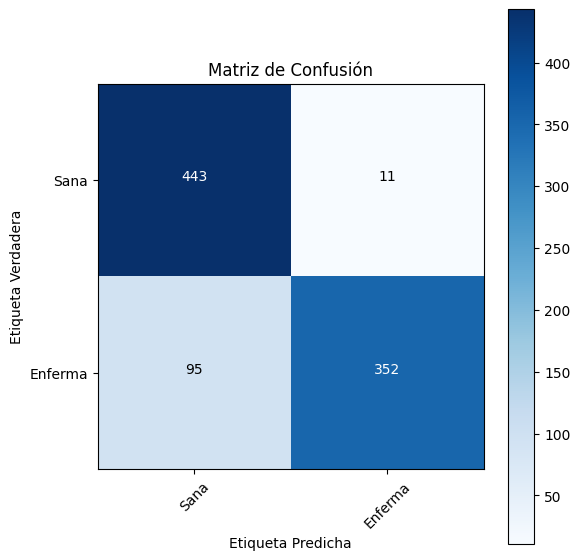

Tasa de falsos positivos (FPR): 2.42 %


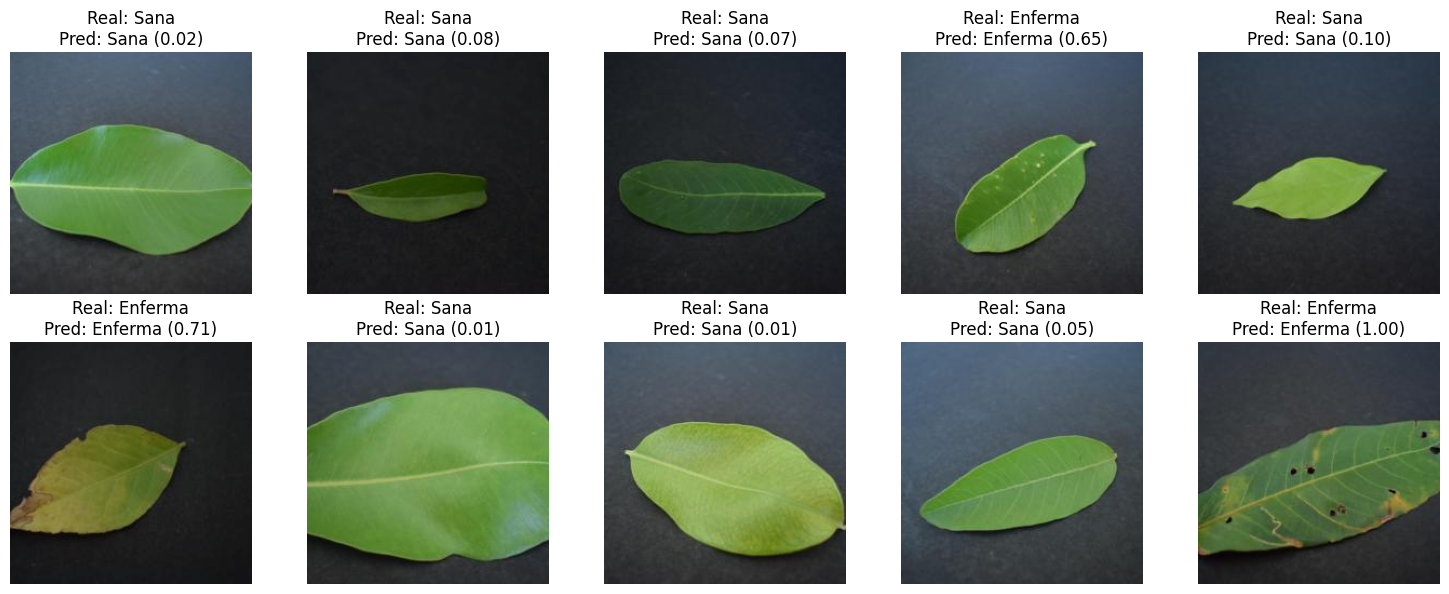

In [14]:
# Pintar curvas
plot_curves(train_losses, test_losses, train_accuracies, test_accuracies)

# Predecir en test para matriz de confusión
model2.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in get_batch_generator(test_data, test_labels, batch_size=64, shuffle=False):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        preds = (outputs.view(-1)>=0.5).long()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

plot_confusion_matrix(all_labels, all_preds, classes=['Sana','Enferma'])

# Calcular tasa de falsos positivos
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
fpr = fp/(fp+tn) if (fp+tn)>0 else 0
print(f"Tasa de falsos positivos (FPR): {fpr*100:.2f} %")

# Evaluar 10 imágenes aleatorias del test dataset
test_indices = np.random.choice(len(test_data), 10, replace=False)
model2.eval()
fig, axes = plt.subplots(2,5, figsize=(15,6))
axes = axes.flatten()
for ax, idx in zip(axes, test_indices):
    img, lbl = test_data[idx], test_labels[idx]
    # Predecimos
    input_img = img.unsqueeze(0).to(device) # [1,C,H,W]
    with torch.no_grad():
        output = model2(input_img)
    pred_prob = output.item()
    pred_label = 1 if pred_prob >= 0.5 else 0
    
    npimg = img.permute(1,2,0).numpy()
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    npimg = std*npimg + mean
    npimg = np.clip(npimg,0,1)
    ax.imshow(npimg)
    ax.set_title(f"Real: {'Sana' if lbl==0 else 'Enferma'}\nPred: {'Sana' if pred_label==0 else 'Enferma'} ({pred_prob:.2f})")
    ax.axis('off')

plt.tight_layout()
plt.show()

# 10. Transfer learning con VGG16

En esta sección, usaremos una red VGG16 preentrenada sobre ImageNet y haremos transfer learning para clasificar hojas sanas o enfermas. La idea es:

1. Descargar el modelo VGG16 preentrenado usando `torchvision.models`.
2. Congelar las capas convolucionales (el feature extractor) para que no se actualicen sus pesos.
3. Reemplazar la parte del clasificador por una capa que se ajuste a nuestra tarea binaria.
4. Entrenar solo la parte del clasificador con nuestros datos de hojas, manteniendo los parámetros del feature extractor fijos.
5. Utilizar `BCELoss` para la pérdida.

### Cargamos la VGG

In [15]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
from torchvision import transforms, models
vgg = models.vgg16(pretrained=True)

# Congelamos las capas convolucionales
for param in vgg.features.parameters():
    param.requires_grad = False

# Reemplazamos la última capa del clasificador
# El feature extractor de VGG16 produce un vector de tamaño 25088 a la entrada del clasificador
num_features = 25088
# Creamos un nuevo clasificador
# Mantenemos las dos capas ocultas originales y sólo cambiamos la última
new_classifier = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 1) # una salida
)

vgg.classifier = new_classifier
for param in vgg.classifier.parameters():
    param.requires_grad = True

vgg.to(device)

C:\Users\juano\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\juano\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
# Cargamos los datos
(train_data, train_labels), (test_data, test_labels) = load_dataset(root)

Cargando imágenes de train en memoria...
Cargando imágenes de test en memoria...


In [18]:
# re-definimos las funciones de entrenamiento y evaluación para añadir la sigmoide, que la red VGG no tiene

def train_one_epoch(model, data, labels, optimizer, device, criterion, batch_size=64):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in get_batch_generator(data, labels, batch_size=batch_size, shuffle=True):
        X_batch = X_batch.to(device)
        y_batch = y_batch.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        outputs = torch.sigmoid(outputs.view(-1))
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / data.size(0)
    return epoch_loss

def evaluate(model, data, labels, device, criterion, batch_size=64):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in get_batch_generator(data, labels, batch_size=batch_size, shuffle=False):
            X_batch = X_batch.to(device)
            y_batch = y_batch.float().to(device)
            outputs = model(X_batch)
            outputs = torch.sigmoid(outputs.view(-1))
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).long()
            total_correct += (preds == y_batch.long()).sum().item()
            total += X_batch.size(0)
    return total_loss / total, total_correct / total

In [19]:
batch_size = 128
epochs = 5
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

criterion = nn.BCELoss()
optimizer = optim.Adam(vgg.classifier.parameters(), lr=0.0001) # entrenamos solo el clasificador

for epoch in range(1, epochs+1):
    train_loss = train_one_epoch(vgg, train_data, train_labels, optimizer, device, criterion, batch_size)
    # Evaluamos en train y test con el modelo en modo eval
    train_loss_eval, train_acc_eval = evaluate(vgg, train_data, train_labels, device, criterion, batch_size)
    test_loss_eval, test_acc_eval = evaluate(vgg, test_data, test_labels, device, criterion, batch_size)
    
    train_losses.append(train_loss_eval)
    test_losses.append(test_loss_eval)
    train_accuracies.append(train_acc_eval)
    test_accuracies.append(test_acc_eval)
    
    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc_eval:.4f} | Test Acc: {test_acc_eval:.4f}")

Epoch 1: Train Loss: 0.3832 | Train Acc: 0.9450 | Test Acc: 0.9256
Epoch 2: Train Loss: 0.1638 | Train Acc: 0.9656 | Test Acc: 0.9245
Epoch 3: Train Loss: 0.0952 | Train Acc: 0.9875 | Test Acc: 0.9279
Epoch 4: Train Loss: 0.0599 | Train Acc: 0.9947 | Test Acc: 0.9279
Epoch 5: Train Loss: 0.0290 | Train Acc: 0.9944 | Test Acc: 0.9323


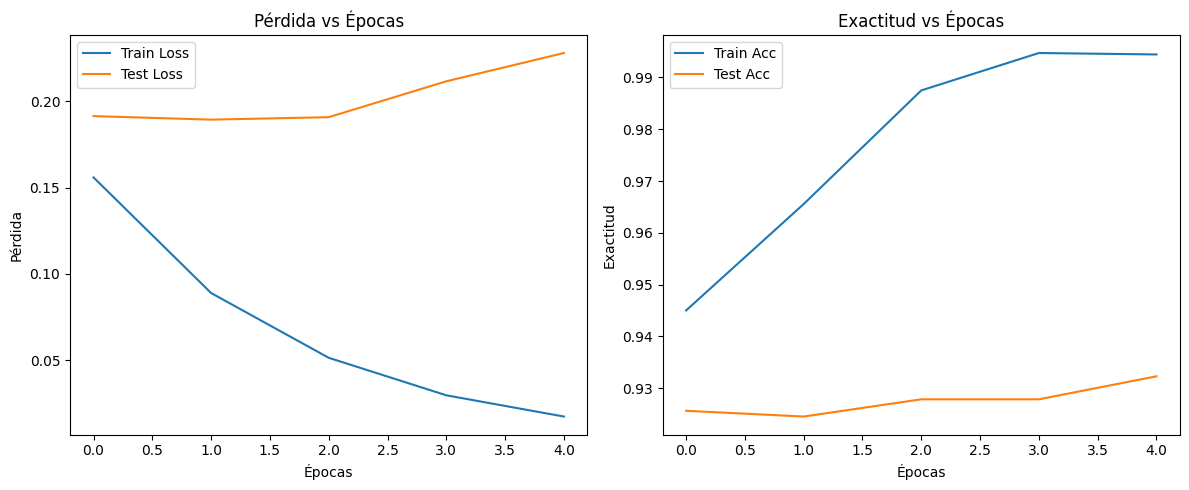

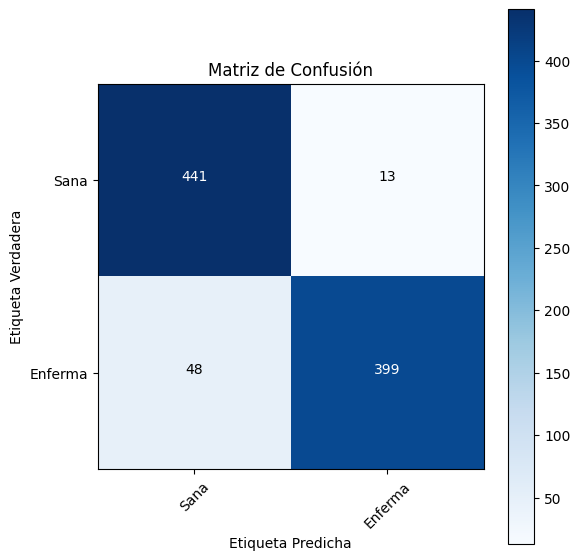

Tasa de falsos positivos (FPR): 2.86 %


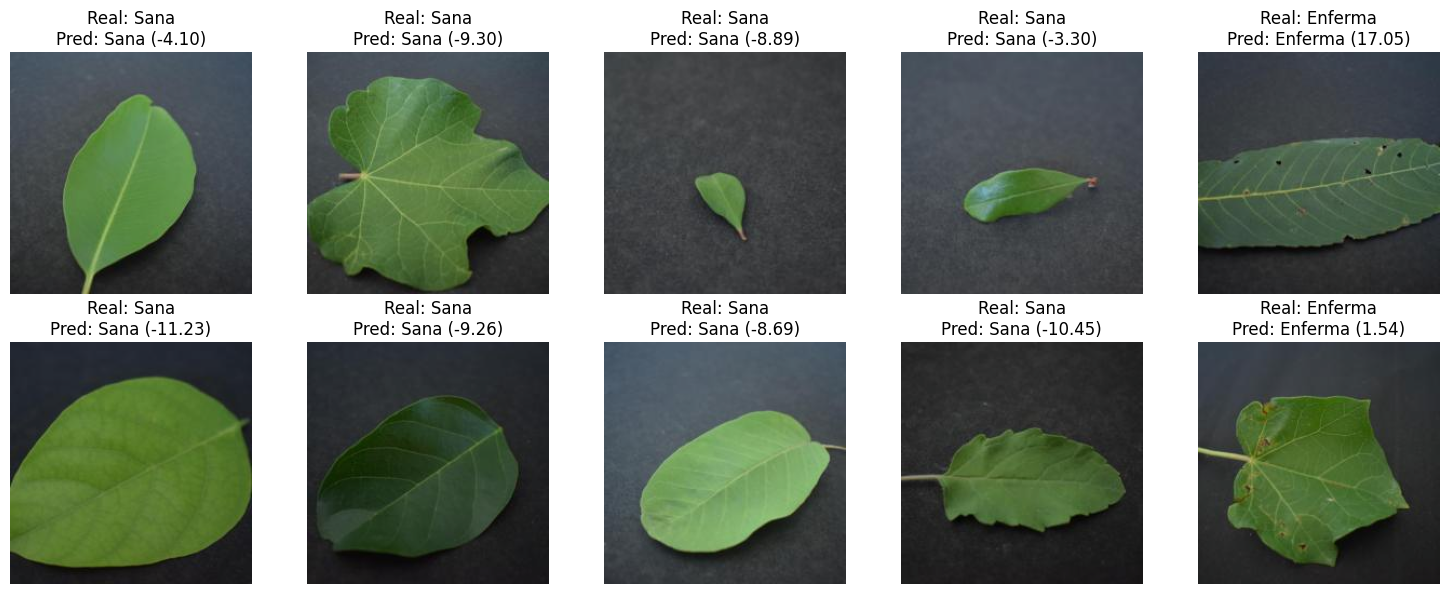

In [20]:
# Pintar curvas
plot_curves(train_losses, test_losses, train_accuracies, test_accuracies)

# Predecir en test para matriz de confusión
vgg.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in get_batch_generator(test_data, test_labels, batch_size=64, shuffle=False):
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg(images)
        preds = (outputs.view(-1)>=0.5).long()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

plot_confusion_matrix(all_labels, all_preds, classes=['Sana','Enferma'])

# Calcular tasa de falsos positivos
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
fpr = fp/(fp+tn) if (fp+tn)>0 else 0
print(f"Tasa de falsos positivos (FPR): {fpr*100:.2f} %")

# Evaluar 10 imágenes aleatorias del test dataset
test_indices = np.random.choice(len(test_data), 10, replace=False)
vgg.eval()
fig, axes = plt.subplots(2,5, figsize=(15,6))
axes = axes.flatten()
for ax, idx in zip(axes, test_indices):
    img, lbl = test_data[idx], test_labels[idx]
    # Predecimos
    input_img = img.unsqueeze(0).to(device) # [1,C,H,W]
    with torch.no_grad():
        output = vgg(input_img)
    pred_prob = output.item()
    pred_label = 1 if pred_prob >= 0.5 else 0
    
    npimg = img.permute(1,2,0).numpy()
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    npimg = std*npimg + mean
    npimg = np.clip(npimg,0,1)
    ax.imshow(npimg)
    ax.set_title(f"Real: {'Sana' if lbl==0 else 'Enferma'}\nPred: {'Sana' if pred_label==0 else 'Enferma'} ({pred_prob:.2f})")
    ax.axis('off')

plt.tight_layout()
plt.show()